In [53]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization , Embedding , Layer , MultiHeadAttention , Input , Dense,LayerNormalization
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

# Data Preperation

In [1]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2024-02-18 12:12:08--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  19.8MB/s    in 0.4s    

2024-02-18 12:12:08 (19.8 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]



In [2]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


In [5]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [6]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=32
FRENCH_SEQUENCE_LENGTH=32
EMBEDDING_DIM=256
BATCH_SIZE=128

In [9]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [10]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [11]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [12]:
split_dataset=text_dataset.map(selector)

In [13]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [14]:
init_dataset=text_dataset.map(separator)

In [15]:
for i in split_dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)


In [16]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [17]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [18]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [19]:
dataset=split_dataset.map(vectorizer)

In [20]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[  2, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[104,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>)


In [21]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [23]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

# Modeling

## Embeddings

In [24]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [26]:
print(positional_encoding(256,64).shape)

(1, 64, 256)


In [29]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

In [30]:
test_input=tf.constant([[2,4,7,21,3,5,0,0]])
emb=Embeddings(8,20000,512)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 512)


In [31]:
mask = emb.compute_mask(test_input)
print(mask)


padding_mask = tf.cast(
    tf.repeat(mask,repeats=tf.shape(mask)[1],axis=0),
    dtype=tf.int32)
print(padding_mask)

tf.Tensor([[ True  True  True  True  True  True False False]], shape=(1, 8), dtype=bool)
tf.Tensor(
[[1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]], shape=(8, 8), dtype=int32)


In [32]:
print(tf.linalg.band_part(
        tf.ones([1,8, 8],dtype=tf.int32),-1,0))

tf.Tensor(
[[[1 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0]
  [1 1 1 1 0 0 0 0]
  [1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 0 0]
  [1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1]]], shape=(1, 8, 8), dtype=int32)


## Costum Multihead model

In [33]:
class CustomSelfAttention(Layer):
  def __init__(self,model_size):
    super(CustomSelfAttention,self).__init__()
    self.model_size=model_size
  def call(self,query,key,value,masking):
    ######## compute scores
    score=tf.matmul(query,key,transpose_b=True)
    ######## scaling
    score/=tf.math.sqrt(tf.cast(self.model_size,tf.float32))
    ######## masking
    masking=tf.cast(masking,dtype=tf.float32)
    score+=(1.-masking)*-1e10
    ######## attention_weights
    attention=tf.nn.softmax(score,axis=-1)*masking
    ######## output
    head=tf.matmul(attention,value)
    return head

In [34]:
attention=CustomSelfAttention(256)
attention(tf.ones([1,8,256]),tf.ones([1,8,256]),tf.ones([1,8,256]),padding_mask)

<tf.Tensor: shape=(1, 8, 256), dtype=float32, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

In [35]:
class CustomMultiHeadAttention(Layer):
  def __init__(self,num_heads,key_dim):
    super(CustomMultiHeadAttention,self).__init__()

    self.num_heads=num_heads
    self.dense_q=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_k=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_v=[Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_o=Dense(key_dim)
    self.self_attention=CustomSelfAttention(key_dim)

  def call(self,query,key,value,attention_mask):
    heads=[]

    for i in range(self.num_heads):
      print("hello", self.dense_q[i](query).shape)
      head=self.self_attention(self.dense_q[i](query),self.dense_k[i](key),
                              self.dense_v[i](value),attention_mask)
      heads.append(head)
    print("head", tf.convert_to_tensor(heads).shape)
    heads=tf.concat(heads,axis=2)
    heads=self.dense_o(heads)
    return heads

## Encoder

In [36]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = CustomMultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):

      if mask is not None:
        mask = tf.cast(
            mask[:,tf.newaxis, :], dtype="int32")
        T = tf.shape(mask)[2]
        padding_mask = tf.repeat(mask,T,axis=1)
      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,
          attention_mask=padding_mask
      )

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

In [37]:
encoder_outputs = TransformerEncoder(512,2048,8)(emb_out)
print(encoder_outputs.shape)

hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
head (8, 1, 8, 64)
(1, 8, 512)


## Decoder

In [38]:
print(tf.linalg.band_part(
        tf.ones([1,8, 8],dtype=tf.int32),-1,0))

tf.Tensor(
[[[1 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0]
  [1 1 1 1 0 0 0 0]
  [1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 0 0]
  [1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1]]], shape=(1, 8, 8), dtype=int32)


In [39]:
class TransformerDecoder(Layer):
  def __init__(self, embed_dim, latent_dim, num_heads,):
    super(TransformerDecoder, self).__init__()
    self.embed_dim = embed_dim
    self.latent_dim = latent_dim
    self.num_heads = num_heads
    self.attention_1=MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.attention_2=MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = tf.keras.Sequential(
        [Dense(latent_dim, activation="relu"),Dense(embed_dim),]
    )
    self.layernorm_1=LayerNormalization()
    self.layernorm_2=LayerNormalization()
    self.layernorm_3=LayerNormalization()
    self.supports_masking = True
  def call(self, inputs, encoder_outputs, enc_mask, mask=None):


    if mask is not None:
      causal_mask=tf.linalg.band_part(
        tf.ones([tf.shape(inputs)[0],
                 tf.shape(inputs)[1],
                 tf.shape(inputs)[1]],dtype=tf.int32),-1,0)
      mask = tf.cast(
          mask[:,tf.newaxis, :], dtype="int32")
      enc_mask = tf.cast(
          enc_mask[:,tf.newaxis, :], dtype="int32")
      T = tf.shape(mask)[2]
      padding_mask = tf.repeat(mask,T,axis=1)
      cross_attn_mask = tf.repeat(enc_mask,T,axis=1)
      combined_mask=tf.minimum(padding_mask,causal_mask)

    attention_output_1 = self.attention_1(
        query=inputs,key=inputs,value=inputs,
        attention_mask=combined_mask,

    )

    out_1 = self.layernorm_1(inputs + attention_output_1)

    attention_output_2= self.attention_2(
        query=out_1,key=encoder_outputs,value=encoder_outputs,
        attention_mask=cross_attn_mask,

    )
    out_2 = self.layernorm_2(out_1 + attention_output_2)

    proj_output = self.dense_proj(out_2)
    return self.layernorm_3(out_2 + proj_output)

In [40]:
enc_mask=mask
decoder_outputs = TransformerDecoder(512,2048,4)(emb_out,encoder_outputs,enc_mask)
print(decoder_outputs.shape)

(1, 8, 512)


## Transformer model

In [41]:
EMBEDDING_DIM=512
D_FF=2048
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=10

In [42]:
encoder_inputs=Input(shape=(None,), dtype="int64", name="input_1")
emb = Embeddings(ENGLISH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)
x = emb(encoder_inputs)
enc_mask = emb.compute_mask(encoder_inputs)

for _ in range(NUM_LAYERS):
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)
encoder_outputs=x

decoder_inputs=Input(shape=(None,), dtype="int64", name="input_2")

x = Embeddings(FRENCH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(decoder_inputs)
for i in range(NUM_LAYERS):
  x=TransformerDecoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x, encoder_outputs,enc_mask)
x=tf.keras.layers.Dropout(0.5)(x)
decoder_outputs=Dense(VOCAB_SIZE, activation="softmax")(x)

transformer = tf.keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embeddings_1 (Embeddings)   (None, 32, 512)              1024000   ['input_1[0][0]']             
                                                          0                                    

## Training

In [43]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [54]:
class Scheduler(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps):
    super(Scheduler, self).__init__()
    self.d_model = tf.cast(d_model, tf.float64)
    self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float64)

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float64)
    return (self.d_model**(-0.5))*tf.math.minimum(step**(-0.5), step * (self.warmup_steps ** -1.5))

In [55]:
WARM_UP_STEPS = 4000
lr_scheduled = Scheduler(EMBEDDING_DIM, WARM_UP_STEPS)

In [56]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(lr_scheduled, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    metrics = ['accuracy'])
    #metrics=[BLEU()],
    #run_eagerly=True)

In [57]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
   1405/Unknown - 456s 308ms/step - loss: 5.4620 - accuracy: 0.2732hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
1405/1405 [==============================] - 541s 369ms/step - loss: 5.4620 - accuracy: 0.2732 - val_loss: 4.6192 - val_accuracy: 0.2824
Epoch 2/10
1405/1405 [==============================] - 508s 362ms/step - loss: 3.1303 - accuracy: 0.5056 - val_loss: 3.4909 - val_accuracy: 0.4401
Epoch 3/10
1405/1405 [==============================] - 508s 361

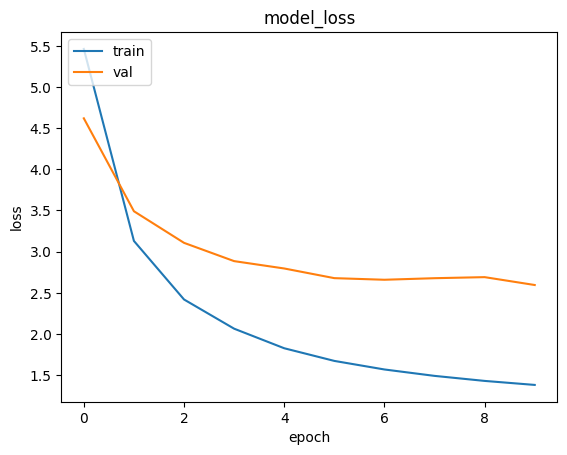

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

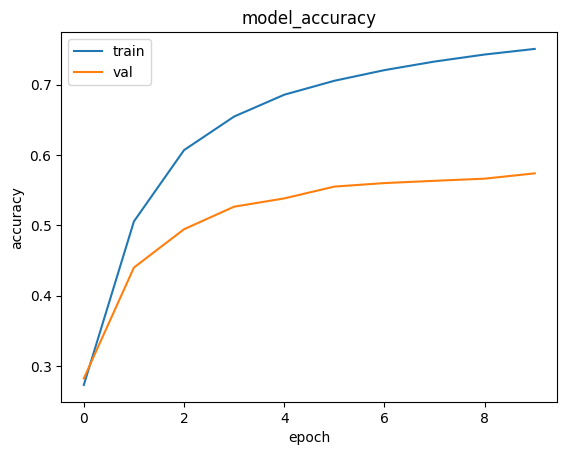

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
transformer.evaluate(val_dataset)

391/391 [==============================] - 78s 132ms/step - loss: 2.5964 - accuracy: 0.5739


[2.596449851989746, 0.5738624334335327]

## Testing

In [61]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [62]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=transformer.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [63]:
translator('What makes you think that it is not true?')

hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
hello (None, 32, 64)
head (8, None, 32, 64)
1/1 [==============================] - 0s 23ms/step


'questce qui vous fait penser que ce nest pas vrai'

In [64]:
translator('Have you ever watched a soccer under the rain?')

1/1 [==============================] - 0s 23ms/step


'astu déjà regardé un football'

In [65]:
translator('I love to write')

1/1 [==============================] - 0s 24ms/step


'jaime écrire à écrire'

In [66]:
translator('Perhaps she will come tomorrow')

1/1 [==============================] - 0s 23ms/step


'peutêtre quelle viendra demain'

In [67]:
translator('Everyone should water his or her tomato plants')

1/1 [==============================] - 0s 23ms/step


'tout le monde devrait eau à son [UNK] de la [UNK]'